<div class="alert alert-info">
<h2> Анализ поведения пользователей мобильного приложения <a class="tocSkip"></h2> 

<b>Цель:</b>  анализ поведения пользователей мобильного приложения стартапа, который продает продукты питания.
    
<b>Задачи:</b>   
   1. Изучить воронку продаж:
    - Как пользователи доходят до покупки?
    - Сколько пользователей доходит до покупки?
    - Сколько — «застревает» на предыдущих шагах? На каких именно?
    
   2. Исследовать результаты A/A/B-эксперимента на трех группах (2 контрольные со старыми шрифтами и одну экспериментальную — с новыми) для выяснения какой шрифт лучше;
 
<b>Содержание:</b>
   1. Предобработка данных;
   2. Анализ данных;
   3. Исследование воронки событий;
   5. Анализ результатов A/A/B-эксперимента;
   6. Выводы.</div>

## Предобработка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from scipy import stats as st
import math as mth

In [2]:
#открыла таблицу и разделалила столбцы
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
#название столбцов были приведены к нижнему регистру и snake_case
logs = logs.rename(columns={'EventName':'event_name', 'DeviceIDHash':'id', 'EventTimestamp':'event_time', 'ExpId':'experiment_id'})
logs.head()

,event_name,id,event_time,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#проверка пропусков 
logs.isna().sum() 

event_name       0
id               0
event_time       0
experiment_id    0
dtype: int64

In [5]:
#проверка типов данных
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   id             244126 non-null  int64 
 2   event_time     244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
#изменение типов данных в столбцах id и experiment_id
logs['id'] = logs['id'].astype('str')
logs['experiment_id'] = logs['experiment_id'].astype('str')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   id             244126 non-null  object
 2   event_time     244126 non-null  int64 
 3   experiment_id  244126 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.5+ MB


In [7]:
#подсчет явных дубликатов
logs.duplicated().sum()

413

In [8]:
#удаление явных дубликатов
logs = logs.drop_duplicates()
logs.duplicated().sum()

0

In [9]:
#добавление столбцов даты и времени и изменение типов данных
logs['date_time']=pd.to_datetime(logs['event_time'], unit='s')

#добавление отдельного столбца дата
logs['date']= pd.DatetimeIndex(logs['date_time']).date
logs

,event_name,id,event_time,experiment_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [10]:
#подсчет количества пользователелей, которые входят в обе группы
(logs
    .groupby('id')
    .agg({'experiment_id' : 'nunique'})
    .query('experiment_id>1')
)


,experiment_id
id,


In [11]:
#проверка в какие группы входят пользователи
exp_group_count = logs.groupby('id').agg({'experiment_id': 'unique'})
exp_group_count

,experiment_id
id,
1000608915523616548,[247]
100724994572555335,[246]
1008242126838007188,[247]
1009503747199967885,[248]
1009745980451513098,[248]
...,...
992321565231279868,[248]
993193057518949787,[248]
995065401066914588,[248]


## Анализ данных

In [12]:
#подсчет количества типов событий в логе
logs_numb = logs['event_name'].nunique()
print('Количество типов событий в логе:', logs_numb)

Количество типов событий в логе: 5


In [13]:
#подсчет количества событий в логе
logs_count = logs['event_name'].count()
print('Количество событий в логе:', logs_count)

Количество событий в логе: 243713


In [14]:
#подсчет количества уникальных пользователей
logs_id = logs['id'].nunique()
print('Количество пользователей в логе:', logs_id)

Количество пользователей в логе: 7551


In [15]:
#подсчет количества событий в среденем приходится на пользователя
logs_id_mean = round(logs['event_name'].count()/logs['id'].nunique(), 1)
print('Количество событий на пользователя в среднем:', logs_id_mean)

Количество событий на пользователя в среднем: 32.3


In [16]:
#максимальная и минимильная дата
date_min = logs['date_time'].dt.date.min() 
date_max = logs['date_time'].dt.date.max()
print('Минимальная дата:', date_min)
print('Максимальная дата:', date_max)

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


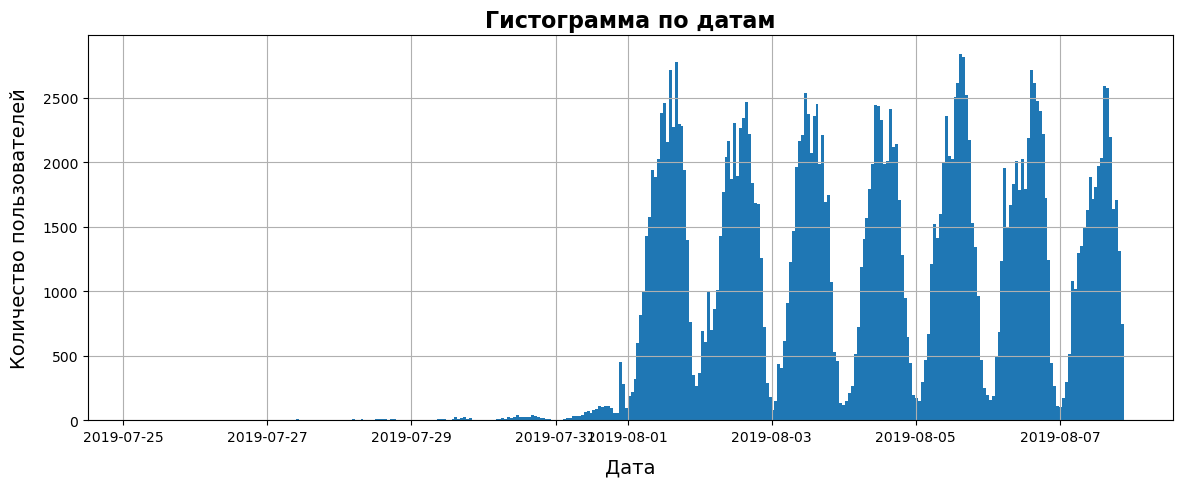

In [17]:
#гистограмма по датам на весь период
logs['date_time'].hist(bins=14*24, figsize=(14, 5)).set_title('Гистограмма по датам', fontsize=16, weight = 'bold')
plt.xlabel("Дата", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество пользователей", labelpad=10, weight='normal', size=14)
plt.show();

**Вывод:** На гистограмме видно, что период с 25 июля по 31 июля 2019 г. нету полных данных. Польные данные представлены с 1 августа 2019 г., поэтому с этого дня была заново построена гистограмма 
Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

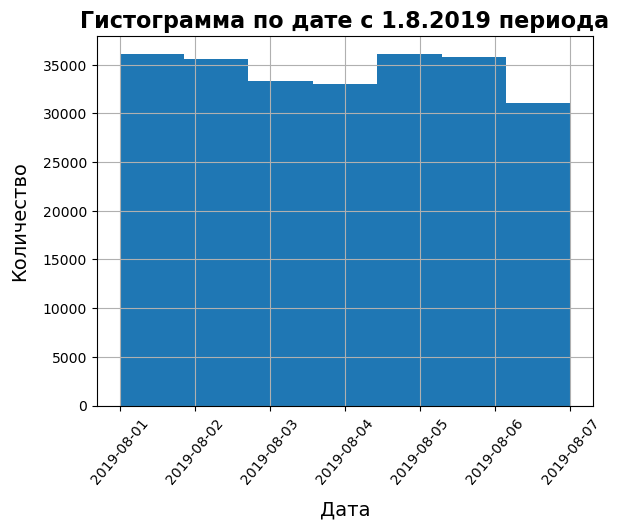

In [18]:
# поскольку с 25.7.2019 до 31.7.2019 значительно небольшое количетсво данных, 
#был взять период с 1.8.2019 для гистограммы
logs['date'] = pd.to_datetime(logs['date'])
logs_period = logs.query('date > "2019-07-31"')
logs_period['date'].hist(bins = 7).set_title('Гистограмма по дате с 1.8.2019 периода', fontsize=16, weight = 'bold')
plt.xlabel("Дата", labelpad=10, weight='normal', size=14)
plt.ylabel("Количество", labelpad=10, weight='normal', size=14)
plt.xticks(rotation=50) 
plt.show()


In [19]:
#подсчет изменений в количестве событий
logs_count_filt = logs_period['event_name'].count()
print('Количество событий в логе в начале:', logs_count)
print('Количество событий после фильтрации:', logs_count_filt)
print('Количество потерянных событий после фильтрации:', (logs_count - logs_count_filt),'или', round((1 - logs_count_filt/logs_count),3)*100,'%')


Количество событий в логе в начале: 243713
Количество событий после фильтрации: 240887
Количество потерянных событий после фильтрации: 2826 или 1.2 %


In [20]:
#подсчет изменений в количестве пользователей
id_count_filt = logs_period['id'].nunique()
print('Количество пользователей в логе в начале:', logs_id)
print('Количество пользователей после фильтрации:', id_count_filt )
print('Количество потерянных пользователей после фильтрации:', (logs_id - id_count_filt ),'или', round((1 - id_count_filt/logs_id),3)*100,'%')

Количество пользователей в логе в начале: 7551
Количество пользователей после фильтрации: 7534
Количество потерянных пользователей после фильтрации: 17 или 0.2 %


In [21]:
#подсчет изменений в количестве пользователей в среднем
logs_id_mean_filt = round(logs_period['event_name'].count()/logs['id'].nunique(), 1)
logs_id_mean_filt
print('Количество событий на пользователя в среднем:', logs_id_mean)
print('Количество событий на пользователя в среднем после фильтрации:', logs_id_mean_filt )
print('Количество потерянных событий на пользователя в среднем после фильтрации:', round((logs_id_mean - logs_id_mean_filt ),3),'или', round((1 - logs_id_mean_filt/logs_id_mean),3)*100,'%')

Количество событий на пользователя в среднем: 32.3
Количество событий на пользователя в среднем после фильтрации: 31.9
Количество потерянных событий на пользователя в среднем после фильтрации: 0.4 или 1.2 %


In [22]:
#подсчет количества уникальных пользователей по группам эксперимента в периоде с 1.8.2019
logs_period.groupby('experiment_id').agg(
    {'id':'nunique'})

,id
experiment_id,
246,2484
247,2513
248,2537


**Выводы:**
- Количество событий составило 243713, а пользователей - 7551. На пользователя в среднем насчитывается 32.3 событий;
- При построении гистограммы по датам на весь период было замечено, что до 1.8.2019 количество данных значительно ниже или отсутствуют. Поэтому для дальнейшего анализа был взят период с 1.8.2019, где данные наиболее полные;
- После было подсчитано количество отброшенных событий (2826) и пользователей (6), а также была проверка наличия пользователей в трех группах.

## Исследование воронки событий

In [23]:
#подсчет как часто встречаются события в логах
logs_period['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

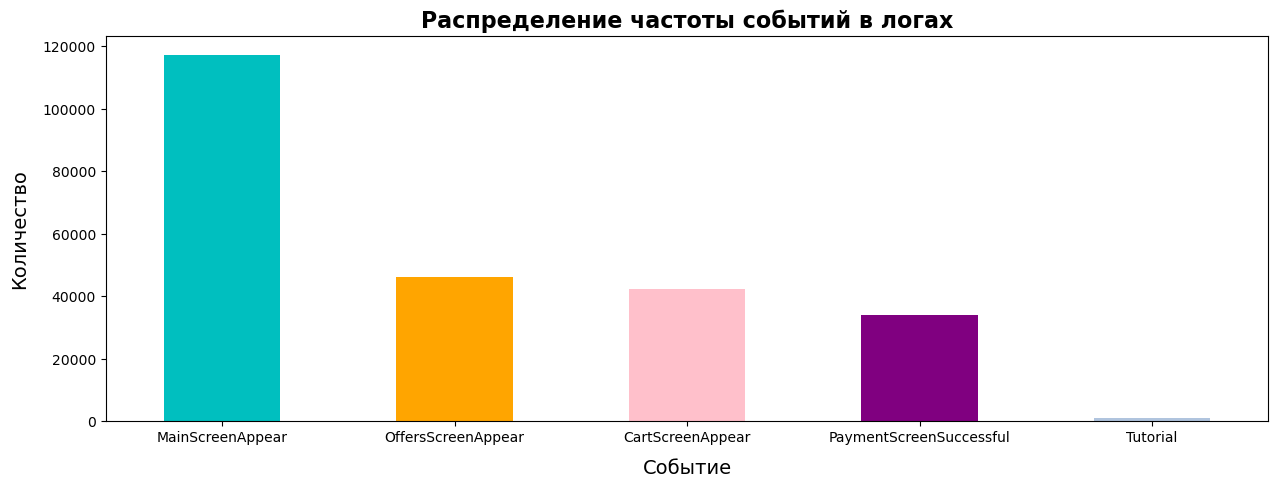

In [24]:
#гистограмма как часто встречаются события в логах
(logs_period['event_name']
 .value_counts()
 .plot(kind='bar', figsize=(15,5), color = ['c', 'orange', 'pink', 'purple', 'lightsteelblue']))
plt.title("Распределение частоты событий в логах", fontsize=16, weight = 'bold')
plt.xlabel("Событие", labelpad=10, weight='normal', size=14)
plt.xticks(rotation=360)
plt.ylabel("Количество", labelpad=10, weight='normal', size=14);

**Выводы:** Всего в логах представлено пять событий. Чаще всего встречается событие "MainScreenAppear", а меньше всего -"Tutorial". 

In [25]:
#подсчет количества пользователей по событиям
logs_id_ev = logs_period.groupby('event_name').agg(
    {'id':'nunique'}).sort_values(by='id', ascending=False).reset_index()
#подсчет доли пользователей
logs_id_ev ['%'] = round((logs_id_ev['id']/logs_id),3)*100
logs_id_ev

,event_name,id,%
0,MainScreenAppear,7419,98.3
1,OffersScreenAppear,4593,60.8
2,CartScreenAppear,3734,49.5
3,PaymentScreenSuccessful,3539,46.9
4,Tutorial,840,11.1


In [26]:
#было удалено событие Tutorial
logs_filtered = logs_id_ev[logs_id_ev['event_name'] != 'Tutorial']
logs_filtered

,event_name,id,%
0,MainScreenAppear,7419,98.3
1,OffersScreenAppear,4593,60.8
2,CartScreenAppear,3734,49.5
3,PaymentScreenSuccessful,3539,46.9


**Выводы:** При подсчете количества пользователей совершивших каждое из представленных событий, на первом месте оказалось событие "MainScreenAppear", то есть переход пользователя на главную страницу приложения. Меньше всего пользователей открывает страницу с "Tutorial", то есть обучающим роликом пользования приложения. Поскольку количество пользователей переходящих на "Tutorial" значительно меньше остальных событий и учитывая, что в настоящее время большинство пользователей умеют пользоватся мобильными приложениями интернет магазинов, событие "Tutorial" было исключено для дальнейшего анализа. 

Предположительная последовательность событий:
1. Main Screen Appear - появляется окно "Главная страница"
2. Offers Screen Appear - появляется окно с предложенными продуктами
3. Cart Screen Appear - появляется окно "Корзина"
4. Payment Screen Successful - появляется окно "Успешная оплата"

* Событие "Tutorial - обучающий ролик пользования приложением" был исключен, поскольку не выстравивается в цепочку

Получается пользователь мобильного приложения стартапа продажи продукты питания начинает с просмотра главной страницы, далее он выбирает продукты, которые он хочет купить. Выбранные продукты пользователь ложит в корзину, а после оплачивает их.


In [27]:
#подсчет доли пользователей, относительно предыдущего шага
pd.options.mode.chained_assignment = None
logs_filtered['ratio_event'] = 0
for i in range(4):
    if i == 0:
        logs_filtered['ratio_event'].loc[i] = 100
    else:
        logs_filtered['ratio_event'].loc[i] = round((logs_filtered['id'].loc[i]/logs_filtered['id'].loc[i-1]),3)*100
logs_filtered        

,event_name,id,%,ratio_event
0,MainScreenAppear,7419,98.3,100.0
1,OffersScreenAppear,4593,60.8,61.9
2,CartScreenAppear,3734,49.5,81.3
3,PaymentScreenSuccessful,3539,46.9,94.8


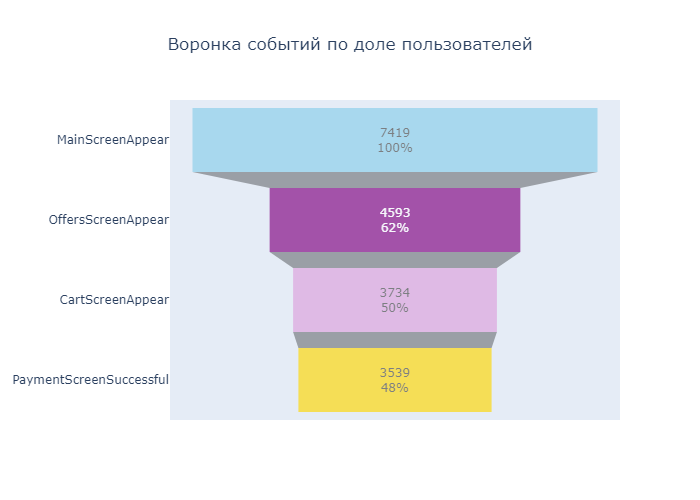

In [28]:
#воронка событий
from plotly import graph_objects as go
fig = go.Figure(go.Funnel(y=logs_filtered['event_name'], x=logs_filtered['id'], textposition = "inside", 
    textinfo = "value+percent initial", opacity = 0.65,marker = {"color": ["skyblue", "purple", "plum", "gold", "lightsalmon"]}))
fig.update_layout(title='Воронка событий по доле пользователей', title_x = 0.5 )
fig.show('png')

**Выводы:** 
- подсчет отношения числа пользователей между событиями показало, что:
  - событие "OffersScreenAppear" (В) к количеству пользователей с событием "MainScreenAppear" (А) - 62%
  - событие "CartScreenAppear" (С) к количеству пользователей с событием "OffersScreenAppear" (В) - 81,3
  - событие "PaymentScreenSuccessful" (D) к количеству пользователей с событием "CartScreenAppear" (С) - 94,8
- получается, что только 62% пользователей после просмотра главной страницы переходят на выбор продуктов питания. Половина пользователей ложат выбранные продукты в корзину (50%), и 48% оплачивают выбранные продукты.

Таким образом, воронка событий показывает, что 38,1% остаются на главной странице приложения. А в итоге, продукты покупают чуть меньше половины пользователей (48%). Однако в отношении числа пользователей между событиями видно, что те, кто все-таки перешли на страницу с продуктами с большей вероятностью, положат и купят выбранные продукты. Поэтому стоит рассмотреть улучшения главной страницы мобильного приложения. Возможно, что информация на главной странице не привлекательная или неправильная. Следующий результаты тестов рассмотрят возможность влияния изменения шрифта на полученный результат по поведению пользователей.

In [29]:
#подсчет доли пользователей, которые доходят от первого события до оплаты
print('Доля пользователей, которая доходит от первого события до оплаты:', round(logs_filtered['id'].iloc[3]/logs_filtered['id'].iloc[0], 2)*100)

Доля пользователей, которая доходит от первого события до оплаты: 48.0


**Выводы:** Подсчёт доли пользователей, которые доходят от главной страницы приложения до оплаты продуктов показал, что больше половины пользователей не покупают продукты (52%).  

## Анализ результатов A/A/B-эксперимента

In [30]:
#подсчет количества уникальных пользователей по группам эксперимента в периоде с 1.8.2019
exper_log = logs_period.groupby('experiment_id').agg(
    {'id':'nunique'}).sort_values(by='id', ascending=False)
exper_log

,id
experiment_id,
248,2537
247,2513
246,2484


**Выводы:** самое большое количество уникальных пользователей у экспериментальной группы (248) - 2537, а в контрольной группе №246 всего 2484 пользователей и в контрольной группе №247 - 2513 пользователей.

In [31]:
#сводная таблица событий по группам эксперимента
exper_event_id = logs_period[logs_period['event_name'] != 'Tutorial'].pivot_table(
    index='event_name', 
    columns='experiment_id', 
    values='id',
    aggfunc='nunique').sort_values('246',ascending=False)
#добавлен столбец объединивший данные контрольных групп 246 и 247 
exper_event_id['246+247'] = exper_event_id['246'] + exper_event_id['247']
exper_event_id

experiment_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


**Вывод:** Было посчитано число пользователей, совершивших это событие в каждой из контрольных групп эксперимента и выбрано самое популярное событие. Самое популярное событие по числу пользователей является переход на главную страницу у всех групп эксперимента. 
Поскольку в эксперименте было 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, для дальнейшего анализа в таблиц добавлен столбец объединивший данные контрольных групп 246 и 247

In [32]:
#добавлена строка объединивший данные контрольных групп 246 и 247 
new_row = {'experiment_id':'246+247','id':2513+2484}
exper_log2 = exper_log.append(pd.Series(new_row, index=exper_log.columns, name='246+247'))
exper_log2

C:\Users\maria\AppData\Local\Temp\ipykernel_21324\3687614357.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,id
experiment_id,
248,2537
247,2513
246,2484
246+247,4997


Далее была проведена проверка различий между группами эксперимента с помощью функции z-теста.
- Для начала была проведена проверка различий между контрольными группами №246 и №247.
- После были проверены различия между контрольной группой №246 с экспериментальной группой № 248
- различия между контрольной группой №247 с экспериментальной группой № 248
- и различия между объединенными данными контрольных групп №246 и №247 с экспериментальной группой № 248

Были проверены следующие гипотезы :
- Нулевая гипотеза: нет оснований считать доли групп пользователей участвующих в эксперименте разными
- Альтенативная гипотеза: между долями групп пользователей участвующих в эксперименте есть значимая разница

In [33]:
# проверка гипотез
def hypothesis_test (experiment1, experiment2, event, alpha):
    event1 = exper_event_id.loc[event, experiment1]
    event2 = exper_event_id.loc[event, experiment2]
    id1 = exper_log2.loc[experiment1, 'id']
    id2 = exper_log2.loc[experiment2, 'id']
    # пропорция успехов в первой группе:
    p1 = event1/id1
    # пропорция успехов во второй группе:
    p2 = event2/id2
    # пропорция успехов в комбинированном датасете:
    p_combined = (event1 + event2) / (id1 + id2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/id1 + 1/id2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие "{}" - p-значение: {p_value:.2f}'.format(event, p_value=p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [34]:
# проверка различий между контрольными группами №246 и №247
for event in exper_event_id.index:
    hypothesis_test('246', '247', event, 0.05)
    print()    

Событие "MainScreenAppear" - p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Проверка №246 и №247:** Контрольные группы для А/А-эксперимента (246 и 247) не имеют статистические критерии разницы между выборками, поэтому выбор контрольных групп корректен.

In [35]:
# проверка различия между контрольной группой №246 с экспериментальной группой № 248
for event in exper_event_id.index:
    hypothesis_test('246', '248', event, 0.05)
    print()  

Событие "MainScreenAppear" - p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [36]:
# проверка различия между контрольной группой №247 с экспериментальной группой № 248
for event in exper_event_id.index:
    hypothesis_test('247', '248', event, 0.05)
    print()  

Событие "MainScreenAppear" - p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [37]:
# проверка  различия между объединенными данными контрольных групп №246 и №247 с экспериментальной группой № 248
for event in exper_event_id.index:
    hypothesis_test('246+247', '248', event, 0.05)
    print()

Событие "MainScreenAppear" - p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:** 
Проверка гипотез не выявила разницу между группами эксперимента, то есть влияние изменения шрифта на поведение пользователей в мобильном приложении не было.
Были проведены проверки со следующиими комбинациями групп
- контрольная группа №246 с экспериментальной группой № 248
- контрольная группа №247 с экспериментальной группой № 248
- объединенные данные контрольных групп №246 и №247 с экспериментальной группой № 248

In [38]:
# проверка различий между контрольными группами №246 и №247 методом Бонферрони при уровне значимости 0.1
for event in exper_event_id.index:
    hypothesis_test('246', '247', event, 0.0125)
    print() 

Событие "MainScreenAppear" - p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
# проверка различия между контрольной группой №246 с экспериментальной группой № 248  методом Бонферрони при уровне значимости 0.1
for event in exper_event_id.index: 
    hypothesis_test('246', '248', event, 0.0125)
    print() 

Событие "MainScreenAppear" - p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
# проверка различия между контрольной группой №247 с экспериментальной группой № 248  методом Бонферрони при уровне значимости 0.1
for event in exper_event_id.index:
    hypothesis_test('247', '248', event, 0.0125)
    print()  

Событие "MainScreenAppear" - p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
# проверка  различия между объединенными данными контрольных групп №246 и №247 с экспериментальной группой № 248  методом Бонферрони при уровне значимости 0.1
for event in exper_event_id.index:
    hypothesis_test('246+247', '248', event, 0.0125)
    print()

Событие "MainScreenAppear" - p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "OffersScreenAppear" - p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "CartScreenAppear" - p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие "PaymentScreenSuccessful" - p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:** При изменении уровня значимости на 0.0125 полученный поправкой Бонферрони, разница между группами эксперимента не была выявлена. Поправка Бонферрони была взята, поскольку снижает вероятность ложноположительного результата эксперимента используя значительно низкий уровень значимости. При расчете уровня значимости метода Шидаки, то для 4 тестов получается 0.0127, что не сильно отличается от числа Бонферрони.

## Выводы 

В данном проекте были изучены данные мобильного приложения стартапа продуктов питания. 

Последовательность действий пользователей приложения начинается с просмотра главной страницы, далее они выбирают продукты, ложат их в корзину, а после оплачивают их. 

С помощью воронки продаж было выявлено, что только 62% пользователей после просмотра главной страницы переходят на выбор продуктов питания. А до оплаты продуктов доходят 48%. Однако, те кто перешли на выбор продуктов чаще всех их покупают. 

Получается, что больше половины пользователей не покупают продукты (52%), а застревают на главной странице. Таким образом, стоит изучить главную страницу мобильного приложения. Возможно информация поданная на главной странице не явлется привлекательной для пользователя или не той, которую они ожидали. 

В проекте также были изучены данные эксперимента A/A/B-теста на влияние измения дизайнерами шрифта во всём приложении стартапа. Результаты эксперимента показали, что изменение шрифта никак не повлияло на поведения пользователей. Тем самым, можно как и оставить старый шрифт, так и заменить на новый. 